<a id = 'top'></a>

# Crime in Boston

**Ying Zhou**

**This report is an on-going work.**

[1. Data Wrangling](#data_wrangling)

[1.1 Dropping non-crimes](#drop3)

[2. Preliminary Analysis](#pre_anal)

[2.1 Crime and day of the week](#day)

[2.2 Is the crime problem in Boston getting better or worse?](#year)

[2.3 Crime and month](#month)

[2.4 What are the most common crimes in Boston?](#common)

[2.5 Where are crimes located in Boston?](#location)

[2.6 What time of day are crimes commited?](#time)

[2.7 How many crimes involve shooting?](#shooting)

[3. Crime rates of neighborhoods of Boston](#crime_rates)

[3.1 Calculate the population of each neighborhood of Boston](#3.0)

[3.2 Determining the neighborhood in which a crime took place](#3.1)

[3.3 Calculate the crime rates](#3.2)

[4. Rates of particular crimes in Boston](#4)

[5. Conclusion](#conclusion)

Let's first import the usual packages.

In [459]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Since we need to draw graphs we need to write our multiliner function here which can help us leave more room for tick labels if the tick labels are really long.

In [460]:
def multiliner(string_list, n):
    length = len(string_list)
    for i in range(length):
        rem = i % n
        string_list[i] = '\n' * rem + string_list[i]
    return string_list

Time to get the data!

In [461]:
df = pd.read_csv('crime.csv')

In [462]:
df.shape

(358066, 17)

In [463]:
df.head(20)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,NaN,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725,"(42.29506405, -71.05672533)"
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,NaN,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230,"(42.34977988, -71.13423049)"
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,NaN,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293,"(42.31013569, -71.07029310)"
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,NaN,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591,"(42.37637003, -71.06759097)"
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,NaN,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099,"(42.32863172, -71.08309899)"
5,I192006543,2629,Harassment,HARASSMENT,B2,181.0,NaN,2019-01-25 13:00:00,2019,1,Friday,13,Part Two,DUDLEY ST,42.324355,-71.074403,"(42.32435506, -71.07440305)"
6,I192006468,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,D4,623.0,NaN,2019-01-25 07:40:00,2019,1,Friday,7,Part Three,BOYLSTON ST,42.347516,-71.092384,"(42.34751600, -71.09238400)"
7,I192006391,3801,Motor Vehicle Accident Response,M/V ACCIDENT - OTHER,B2,NaN,NaN,2019-01-24 21:55:00,2019,1,Thursday,21,Part Three,HUMBOLDT AVE,NaN,NaN,"(0.00000000, 0.00000000)"
8,I192006323,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,B2,266.0,NaN,2019-01-24 16:09:00,2019,1,Thursday,16,Part Three,MORELAND ST,42.323519,-71.078158,"(42.32351940, -71.07815793)"
9,I192006257,1402,Vandalism,VANDALISM,C11,257.0,NaN,2019-01-24 14:04:00,2019,1,Thursday,14,Part Two,HANCOCK ST,42.312521,-71.064350,"(42.31252055, -71.06434966)"


<a id = 'data_wrangling'></a>
[Return to top](#top)
# 1. Data Wrangling

Since `incident_number` is unique let's make it the index. Then we should drop `location` due to redundancy. Moreover we need to fill the NaNs in `shooting` because NaNs in this case indicate the absence of shooting in the crime.

In [464]:
#df.set_index('incident_number', inplace = True)
df['shooting'].fillna(0, inplace = True)
df.drop(columns = ['location'], inplace = True)

In [465]:
df.head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
0,I192006902,1402,Vandalism,VANDALISM,C11,364.0,0,2019-01-25 22:30:00,2019,1,Friday,22,Part Two,CENTRE ST,42.295064,-71.056725
1,I192006833,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,794.0,0,2019-01-25 12:41:00,2019,1,Friday,12,Part One,GLENVILLE AVE,42.349780,-71.134230
2,I192006763,619,Larceny,LARCENY ALL OTHERS,C11,333.0,0,2019-01-09 11:14:00,2019,1,Wednesday,11,Part One,MOUNT EVERETT ST,42.310136,-71.070293
3,I192006685,3301,Verbal Disputes,VERBAL DISPUTE,A15,58.0,0,2019-01-25 23:23:00,2019,1,Friday,23,Part Three,PHIPPS ST,42.376370,-71.067591
4,I192006619,619,Larceny,LARCENY ALL OTHERS,B2,280.0,0,2019-01-25 17:53:00,2019,1,Friday,17,Part One,DUDLEY ST,42.328632,-71.083099


Now let's check the dtypes.

In [466]:
df.dtypes

incident_number         object
offense_code             int64
offense_code_group      object
offense_description     object
district                object
reporting_area         float64
shooting                object
occurred_on_date        object
year                     int64
month                    int64
day_of_week             object
hour                     int64
ucr_part                object
street                  object
lat                    float64
long                   float64
dtype: object

`reporting_area` should be int64s instead of a float64s. But before that let's first fix the remaining NaNs.

In [467]:
df.isna().sum()

incident_number            0
offense_code               0
offense_code_group         0
offense_description        0
district                1948
reporting_area         22719
shooting                   0
occurred_on_date           0
year                       0
month                      0
day_of_week                0
hour                       0
ucr_part                  99
street                 11413
lat                    22403
long                   22403
dtype: int64

It sees that there are a lot of crimes missing numerous crucial data. They are unlikely to be filled anyway so let's first focus on analyzing data that does not require them. I think we should allow `reporting_area` to be float64 for now.

<a id = 'drop3'></a>
[Return to top](#top)
## 1.1 Dropping non-crimes

Now let's analyze the crime classes.

In [468]:
df_od = df.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [469]:
df_od

,counts
offense_description,
SICK/INJURED/MEDICAL - PERSON,21449
INVESTIGATE PERSON,20838
M/V - LEAVING SCENE - PROPERTY DAMAGE,18234
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
VERBAL DISPUTE,14811
TOWED MOTOR VEHICLE,12658
INVESTIGATE PROPERTY,12606
THREATS TO DO BODILY HARM,10233


Some large classes here aren't crimes at all. We have to fix that. Let's focus on the UCR Part numbers.

According to [Wikipedia](https://en.wikipedia.org/wiki/Uniform_Crime_Reports), UCR part I and part II offenses are actually offenses. As for part III let's check what they actually are.

In [470]:
df_ucr = df.groupby('ucr_part').size().reset_index(name = 'counts').set_index('ucr_part')

In [471]:
df_ucr

,counts
ucr_part,
Other,1401
Part One,68881
Part Three,178540
Part Two,109145


In [472]:
df_p3 = df.loc[df['ucr_part'] == 'Part Three']

In [473]:
df_3d = df_p3.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [474]:
df_3d

,counts
offense_description,
AIRCRAFT INCIDENTS,49
ANIMAL CONTROL - DOG BITES - ETC.,400
ANIMAL INCIDENTS,308
DANGEROUS OR HAZARDOUS CONDITION,335
DEATH INVESTIGATION,1339
DEMONSTRATIONS/RIOT,293
EXPLOSIVES - TURNED IN OR FOUND,16
"FIRE REPORT - CAR, BRUSH, ETC.",586
"FIRE REPORT - HOUSE, BUILDING, ETC.",1393


Most of them are non-criminal or unrelated to what we usually think of as "crimes". I think we should ignore the entire part 3 or at least most part 3 incidents. Our report is about crime in Boston, not towed motor vehicles in Boston or accidents in Boston.

Now let's focus on "Other". What does that mean?

In [475]:
df_other = df.loc[df['ucr_part'] == 'Other']

In [476]:
df_otherd = df_other.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [477]:
df_otherd

,counts
offense_description,
ARSON,98
AUTO THEFT - OUTSIDE - RECOVERED IN BOSTON,1
B&E NON-RESIDENCE DAY - NO PROP TAKEN,2
B&E RESIDENCE DAY - NO PROP TAKEN,3
KILLING OF FELON BY POLICE,1
MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE,2
MANSLAUGHTER - VEHICLE - NEGLIGENCE,6
PROPERTY - CONCEALING LEASED,30
RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON),1178


OK so these are almost all crimes or at the very least these are crime-related. This will be included then.

What about NaN?

In [478]:
df_ucrna = df.loc[df['ucr_part'].isnull()]

In [479]:
df_nad = df_ucrna.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description')

In [480]:
df_nad

,counts
offense_description,
HOME INVASION,84
HUMAN TRAFFICKING - COMMERCIAL SEX ACTS,8
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE,2
INVESTIGATE PERSON,5


OK so most of them are crimes. I will drop the 5 investigate person incidents though. Now we will drop all Part 3 and investigate person incidents.

In [481]:
df_clean = df.loc[(df['ucr_part'] != 'Part Three') & (df['offense_description'] != 'INVESTIGATE PERSON')]

In [482]:
df_clean.shape

(179521, 16)

<a id = 'pre_anal'></a>
[Return to top](#top)
# 2. Preliminary Analysis

<a id = 'day'></a>
[Return to top](#top)
## 2.1 Crime and day of the week

In [483]:
df_day = df_clean.groupby('day_of_week').size().reset_index(name = 'counts').set_index('day_of_week')

In [484]:
df_day

,counts
day_of_week,
Friday,27262
Monday,25787
Saturday,24780
Sunday,22123
Thursday,26480
Tuesday,26361
Wednesday,26728


It seems that Fridays in Boston are unusually filled with crimes while the opposite is true for Sundays and to a less extant Saturdays and Mondays.

Before plotting the graph we have to fix the ordering.

In [485]:
df_day.reset_index(inplace = True)

In [486]:
df_day['day_of_week'] = pd.Categorical(df_day['day_of_week'], categories = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], ordered = True)

In [487]:
df_day.set_index('day_of_week', inplace = True)

In [488]:
df_day.sort_values(by = 'day_of_week', inplace = True)

Time to do some plotting!

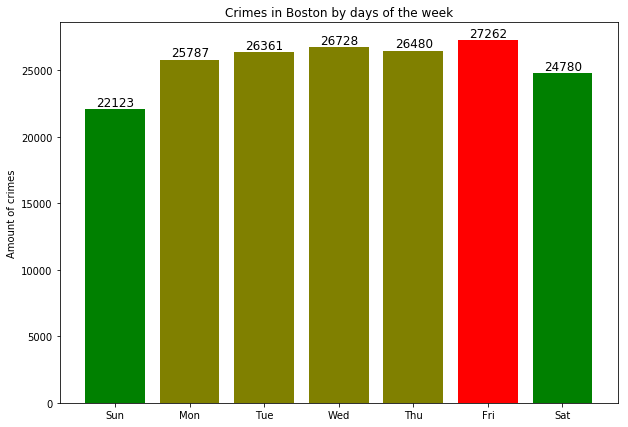

In [489]:
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(111)
ind = np.arange(7)
crimes_by_day = df_day['counts']
rects = ax.bar(ind, crimes_by_day, width = 0.8, color = ['green','olive','olive','olive','olive','red','green'])
ax.set_xticks(ind)
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_title('Crimes in Boston by days of the week')
ax.set_ylabel('Amount of crimes')
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + 0.15, 1.01 * height, height, fontsize = 12)

<a id = 'year'></a>
[Return to top](#top)
## 2.2 Is the crime problem in Boston getting better or worse?

In [490]:
df_year = df_clean.groupby('year').size().reset_index(name = 'counts').set_index('year')

In [491]:
df_year

,counts
year,
2015,30296
2016,50512
2017,48455
2018,47489
2019,2769


Disregarding 2015 and 2019 since there are not enough data about them in the data set it is easy to see that the crime situation in 2017 is slightly better than the situation in 2016. The crime situation in 2018 is slightly better than the situation in 2017.

In [492]:
df_year.drop(labels = [2015,2019], inplace = True)

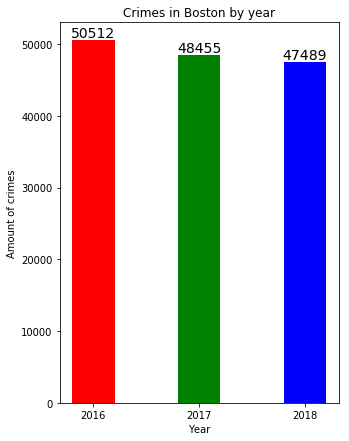

In [493]:
fig2 = plt.figure(figsize = (5,7))
ind2 = np.arange(3)
ax2 = plt.subplot(111)
rects = ax2.bar(ind2, df_year['counts'], width = 0.4, color = ['red','green','blue'])
ax2.set_xticks(ind2)
ax2.set_xticklabels([2016,2017,2018])
ax2.set_xlabel('Year')
ax2.set_ylabel('Amount of crimes')
ax2.set_title('Crimes in Boston by year')
for rect in rects:
    height = rect.get_height()
    ax2.text(rect.get_x() - 0.01, 1.01 * height, height, fontsize = 14)

<a id = 'month'></a>
[Return to top](#top)
## 2.3 Crime and month

Are there more crimes in summers or in winters?

Since the data set is from Aug.2015 to Jan. 2019 let's analyze the trends from 2016 to 2018.

In [494]:
df_1618 = df_clean.loc[(df_clean['year'] > 2015) & (df_clean['year'] < 2019)]

In [495]:
df_1618.shape

(146456, 16)

In [496]:
df_month = df_1618.groupby('month').size().reset_index(name = 'counts').set_index('month')

In [497]:
df_month

,counts
month,
1,11932
2,10765
3,11762
4,12012
5,12949
6,13047
7,13194
8,13348
9,12643


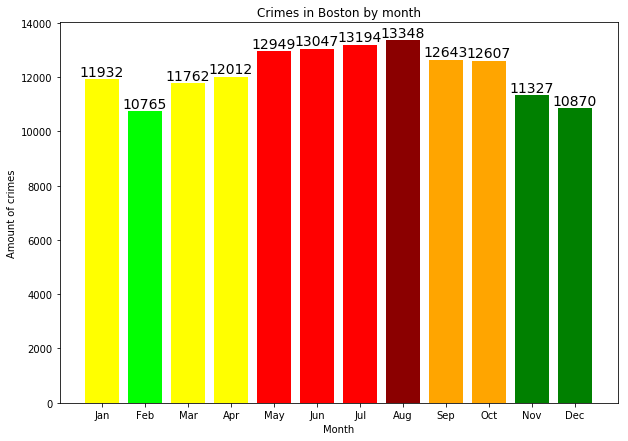

In [498]:
fig3 = plt.figure(figsize = (10,7))
ind3 = np.arange(12)
ax3 = plt.subplot(111)
rects = ax3.bar(ind3, df_month['counts'], width = 0.8,color = ['yellow','lime','yellow','yellow','red','red','red','darkred','orange','orange','green','green'])
ax3.set_xticks(ind3)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3.set_xlabel('Month')
ax3.set_ylabel('Amount of crimes')
ax3.set_title('Crimes in Boston by month')
for rect in rects:
    height = rect.get_height()
    ax3.text(rect.get_x() - 0.13, 1.01 * height, height, fontsize = 14)

It seems that there is more crime during summer months and less crime during winter ones. It's possible that crime is fairly weather-dependent. Is this trend true for all three full years?

<a id = 'common'></a>
[Return to top](#top)
## 2.4 What are the most common crimes in Boston?

In [499]:
df_ocg = df_clean.groupby('offense_code_group').size().reset_index(name = 'counts').set_index('offense_code_group').sort_values(by = 'counts', ascending = False)

In [500]:
df_ocg

,counts
offense_code_group,
Larceny,29257
Other,19091
Drug Violation,18502
Simple Assault,17799
Vandalism,17132
Larceny From Motor Vehicle,12029
Aggravated Assault,8868
Violations,6730
Fraud,6660


In [501]:
ax41

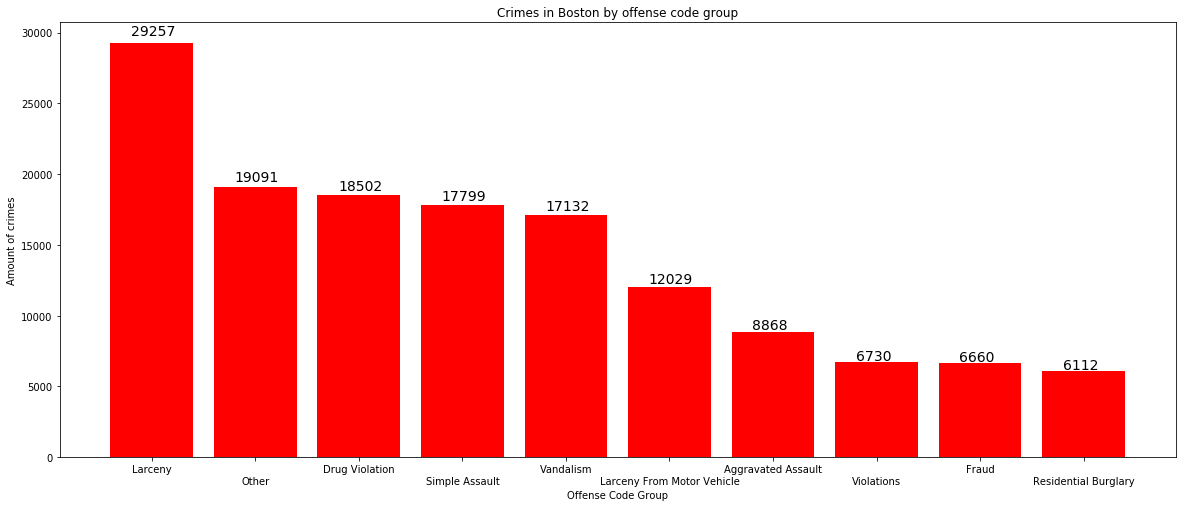

In [502]:
fig41 = plt.figure(figsize = (20,8))
ind41 = np.arange(10)
ax41 = plt.subplot(111)
y_data = df_ocg['counts'].head(10)
df_riocg = df_ocg.reset_index()
rects = ax41.bar(ind41, y_data, width = 0.8,color = 'r')
ax41.set_xticks(ind41)
ax41.set_xticklabels(multiliner(df_ocg.index.tolist()[:10], 2))
ax41.set_xlabel('Offense Code Group')
ax41.set_ylabel('Amount of crimes')
ax41.set_title('Crimes in Boston by offense code group')
for rect in rects:
    height = rect.get_height()
    ax41.text(rect.get_x() + 0.2, 1.02 * height, height, fontsize = 14)

In [503]:
df_od = df_clean.groupby('offense_description').size().reset_index(name = 'counts').set_index('offense_description').sort_values(by = 'counts', ascending = False)

In [504]:
df_od

,counts
offense_description,
VANDALISM,16847
ASSAULT SIMPLE - BATTERY,16589
THREATS TO DO BODILY HARM,10233
LARCENY THEFT FROM BUILDING,10199
LARCENY THEFT FROM MV - NON-ACCESSORY,9865
LARCENY SHOPLIFTING,8990
LARCENY ALL OTHERS,6747
ASSAULT - AGGRAVATED - BATTERY,5544
FRAUD - FALSE PRETENSE / SCHEME,5033


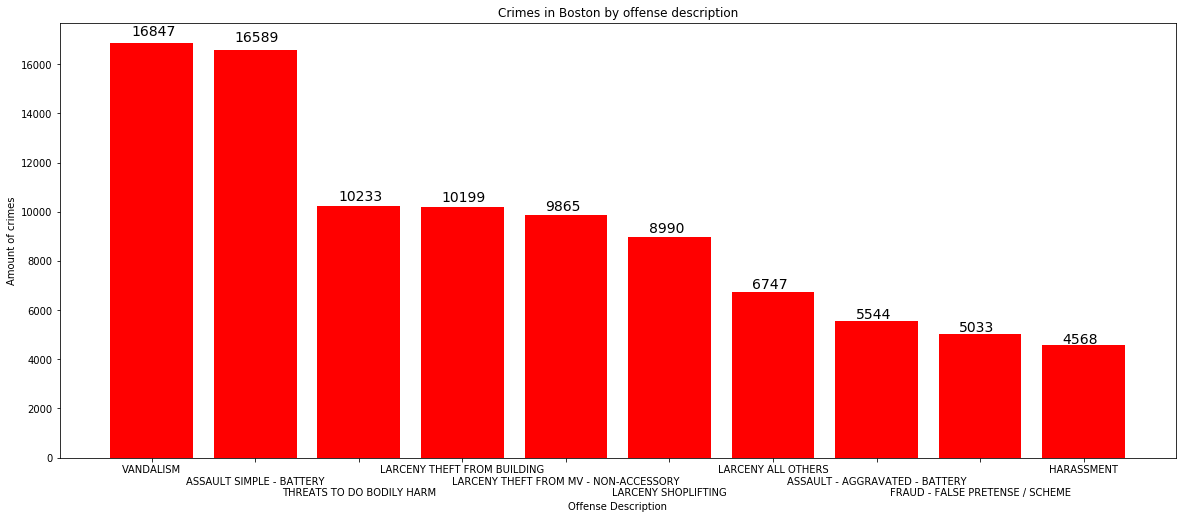

In [505]:
fig42 = plt.figure(figsize = (20,8))
ind42 = np.arange(10)
ax42 = plt.subplot(111)
y_data = df_od['counts'].head(10)
df_riod = df_od.reset_index()
rects = ax42.bar(ind42, y_data, width = 0.8,color = 'r')
ax42.set_xticks(ind42)
ax42.set_xticklabels(multiliner(df_od.index.tolist()[:10], 3))
ax42.set_xlabel('Offense Description')
ax42.set_ylabel('Amount of crimes')
ax42.set_title('Crimes in Boston by offense description')
for rect in rects:
    height = rect.get_height()
    ax42.text(rect.get_x() + 0.2, 1.02 * height, height, fontsize = 14)

<a id = 'location'></a>
[Return to top](#top)
## 2.5 Where are crimes located in Boston?

In [506]:
df_districts = df_clean.groupby('district').size().reset_index(name = 'counts').set_index('district').sort_values('counts', ascending = False)

In [507]:
df_districts

,counts
district,
B2,28366
D4,27516
C11,22960
A1,22268
B3,18252
C6,13459
D14,10336
E13,9925
E18,8593


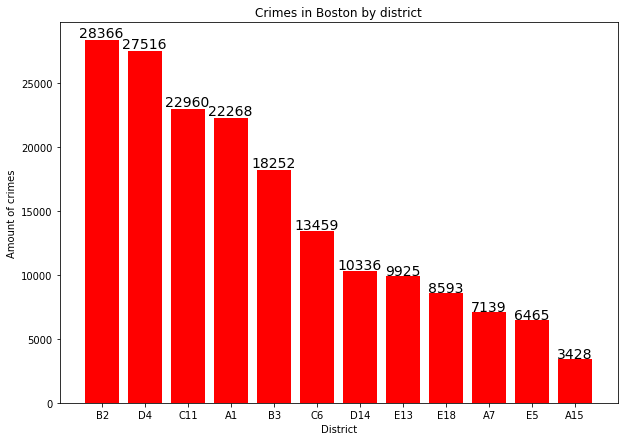

In [508]:
fig5 = plt.figure(figsize = (10,7))
ind5 = np.arange(12)
ax5 = plt.subplot(111)
rects = ax5.bar(ind5, df_districts['counts'], width = 0.8,color = 'r')
ax5.set_xticks(ind5)
ax5.set_xticklabels(df_districts.index)
ax5.set_xlabel('District')
ax5.set_ylabel('Amount of crimes')
ax5.set_title('Crimes in Boston by district')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax5.text(hor, 1.01 * height, height, fontsize = 14)

It seems that B2, D4, C11 and A1 have the most crimes. On the other hand A15, A7, E18 and E13 have the least amount of crimes.

Analysis of whether a certain police district of Boston necessarily has more crimes compared to some other police district per capita is impossible because different police district differ a lot in terms of population size.

However analyzing the same information using neighborhood boundaries should be possible.

<a id = 'time'></a>
[Return to top](#top)
## 2.6 What time of day are crimes commited?

In [509]:
df_hour = df_clean.groupby('hour').size().reset_index(name = 'counts').set_index('hour')

In [510]:
df_hour

,counts
hour,
0,9317
1,5511
2,4647
3,2471
4,1857
5,1578
6,2296
7,3895
8,6315


The most crimes are actually commited between 4PM and 8PM. Between 1AM and 8AM few crimes are commited.

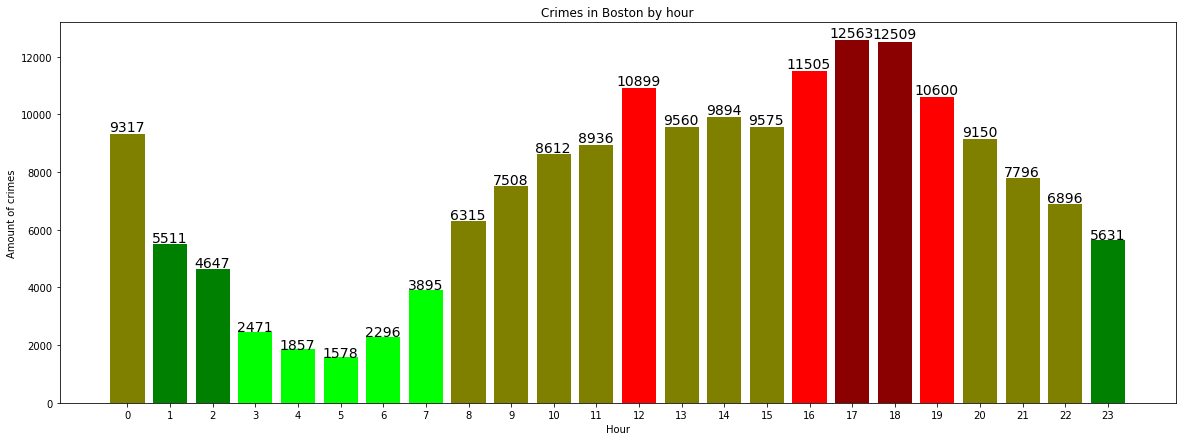

In [511]:
fig6 = plt.figure(figsize = (20,7))
ind6 = np.arange(24)
ax6 = plt.subplot(111)
color = []
for i in range(24):
    amount = df_hour.loc[i, 'counts']
    if amount > 12000:
        color.append('darkred')
    elif amount < 4000:
        color.append('lime')
    elif amount > 10000:
        color.append('r')
    elif amount < 6000:
        color.append('g')
    else:
        color.append('olive')
rects = ax6.bar(ind6, df_hour['counts'], width = 0.8,color = color)
ax6.set_xticks(ind6)
ax6.set_xticklabels(df_hour.index)
ax6.set_xlabel('Hour')
ax6.set_ylabel('Amount of crimes')
ax6.set_title('Crimes in Boston by hour')
for rect in rects:
    height = rect.get_height()
    if height > 9999:
        hor = rect.get_x() - 0.13
    else:
        hor = rect.get_x() - 0.03
    ax6.text(hor, 1.01 * height, height, fontsize = 14)

<a id = 'shooting'></a>
[Return to top](#top)
## 2.7 How many crimes involve shooting?

In [512]:
df_shooting = df_clean.groupby('shooting').size().reset_index(name = 'counts').set_index('shooting')

In [513]:
df_shooting

,counts
shooting,
0,178333
Y,1188


OK so Y represents shooting.

In [514]:
shooting_rate = df_shooting.loc['Y', 'counts']/df_clean.shape[0]

In [515]:
shooting_rate

0.006617610196021635

About 0.66% of all crimes involve shooting.

Text(0.5,1,'What percentage of crimes involve shooting?')

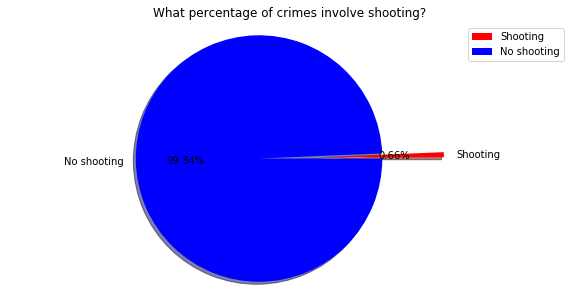

In [516]:
fig7 = plt.figure(figsize = (10,5))
labels = ['Shooting', 'No shooting']
ax7 = plt.subplot(111)
size = [shooting_rate, 1 - shooting_rate]
ax7.pie(size, explode = [0.5,0], labels = labels, autopct = '%1.2f%%', shadow = True, colors = ['red','blue'])
ax7.axis('equal')
ax7.legend()
ax7.set_title('What percentage of crimes involve shooting?')

<a id = 'crime_rates'></a>
[Return to top](#top)
# 3. Crime rates of neighborhoods of Boston

We are going to continue our exploration in 2.5 . It is impossible to calculate the population of police districts. However the population of neighborhoods of Boston are still possible to obtain. We are going to use the definitions of neighborhoods on the [Analyze Boston](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0) website.

<a id = '3.0'></a>
## 3.1 Calculate the population of each neighborhood of Boston

In [517]:
import json
with open('Boston_Neighborhoods.geojson', 'r') as f:
    boston_geojson = json.load(f)
features = boston_geojson['features']
nbh_list = []
for feature in features:
    nbh_list.append(feature['properties']['Name'])
print(nbh_list)

['Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood', 'Bay Village', 'Leather District', 'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown', 'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston', 'Harbor Islands']


In [518]:
boston_geojson['features'][0]['geometry']

{'type': 'MultiPolygon',
 'coordinates': [[[[-71.12592717485386, 42.272013107957406],
    [-71.12610933458738, 42.2716219294518],
    [-71.12603188298199, 42.27158985153841],
    [-71.12571713956957, 42.27152070474045],
    [-71.12559042372907, 42.27146017841939],
    [-71.12523676125656, 42.271387313901805],
    [-71.12522437821433, 42.271425073651166],
    [-71.12489533053173, 42.27134458090032],
    [-71.12482468090687, 42.271318140479686],
    [-71.12485155056099, 42.27124753819149],
    [-71.12476329046935, 42.270292339717635],
    [-71.12470249712558, 42.270295367758344],
    [-71.12259088359436, 42.2700534081311],
    [-71.1223931813923, 42.27003085475475],
    [-71.12252039300371, 42.269427196690025],
    [-71.12214745279846, 42.26937277217365],
    [-71.12192848881409, 42.27038614438027],
    [-71.1221406576364, 42.27041692631439],
    [-71.1220178727131, 42.27096341291406],
    [-71.12201165286537, 42.271016446462525],
    [-71.12190239148987, 42.27099668884986],
    [-71.121

In [519]:
nbh_list.sort()

In [520]:
nbh_list

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Leather District',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

Now it's time to determine the population of each neighborhood. The data is also obtained from [Analyze Boston](https://data.boston.gov/dataset/boston-neighborhood-demographics) because different websites have completely different definitions of many neighborhoods. Here according to the City of Boston Chinatown and Leather district have been merged into Downtown and Bay Village is merged into South End.

In [521]:
nbh_list.remove('Chinatown')
nbh_list.remove('Bay Village')
nbh_list.remove('Leather District')

In [522]:
nbh_list

['Allston',
 'Back Bay',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway',
 'Harbor Islands',
 'Hyde Park',
 'Jamaica Plain',
 'Longwood',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South Boston Waterfront',
 'South End',
 'West End',
 'West Roxbury']

In [523]:
nbh_pop = {
    'Allston':22312,
 'Back Bay':16622,
 'Beacon Hill':9023,
 'Brighton':52685,
 'Charlestown':16439,
 'Dorchester':114249,
 'Downtown':15992,
 'East Boston':40508,
 'Fenway':33895,
 'Harbor Islands':535,
 'Hyde Park':32317,
 'Jamaica Plain':35541,
 'Longwood':4861,
 'Mattapan':22500,
 'Mission Hill':16874,
 'North End':8608,
 'Roslindale':26368,
 'Roxbury':49111,
 'South Boston':31110,
 'South Boston Waterfront':2564,
 'South End':29612,
 'West End':5423,
 'West Roxbury':30445
}

In [524]:
df_nb = pd.DataFrame.from_dict(data = nbh_pop, orient = 'index', columns = ['population'])

In [525]:
df_nb

,population
Allston,22312
Back Bay,16622
Beacon Hill,9023
Brighton,52685
Charlestown,16439
Dorchester,114249
Downtown,15992
East Boston,40508
Fenway,33895
Harbor Islands,535


We need to preserve the data.

In [526]:
df_nb.to_csv('population.csv')

<a id = '3.1'></a>
[Return to top](#top)
## 3.2 Determining the neighborhood in which a crime took place

Since we already have the information about the population of the neighborhoods. Now we need to determine the number of crimes that take place within a neighborhood. All the crimes that did not have latitude and longitude need to be dropped so we may have some slight underestimation and distortion.

In order to do so we need to make sure that we can attribute a crime to a neighborhood we need to use the Geojson data from [Analyze Boston](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0).

In [527]:
from shapely.geometry import Point, shape

In [541]:
def point_to_neighborhood (lat, long, geojson):
    point = Point(long, lat)
    features = geojson['features']
    for feature in features:
        polygon = shape(feature['geometry'])
        neighborhood = feature['properties']['Name']
        if polygon.contains(point):
            if neighborhood == 'Chinatown' or neighborhood == 'Leather District':
                return 'Downtown'
            elif neighborhood == 'Bay Village':
                return 'South End'
            else:
                return neighborhood
    print(f'Point ({long},{lat}) is not in Boston.')
    return None

In [529]:
boston_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 27,
    'Name': 'Roslindale',
    'Acres': 1605.5682375,
    'Neighborhood_ID': '15',
    'SqMiles': 2.51,
    'ShapeSTArea': 69938272.92557049,
    'ShapeSTLength': 53563.912597056624},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-71.12592717485386, 42.272013107957406],
       [-71.12610933458738, 42.2716219294518],
       [-71.12603188298199, 42.27158985153841],
       [-71.12571713956957, 42.27152070474045],
       [-71.12559042372907, 42.27146017841939],
       [-71.12523676125656, 42.271387313901805],
       [-71.12522437821433, 42.271425073651166],
       [-71.12489533053173, 42.27134458090032],
       [-71.12482468090687, 42.271318140479686],
       [-71.12485155056099, 42.27124753819149],
       [-71.12476329046935, 42.270292339717635],
       [-71.12470249712558, 42.270295367758344],
       [-71.12259088359436, 42.2700534081311],
       [-71.1223931813923, 42.270030

In [530]:
point_to_neighborhood(42.372269, -71.039015, boston_geojson)

'East Boston'

In [531]:
df_nafree = df_clean.dropna(subset = ['lat','long'])

In [532]:
df_nafree.shape

(169577, 16)

In [533]:
df_nafree.shape[0]/df_clean.shape[0]

0.9446081516925596

So we can retain 94%+ of the data. That's good.

In [543]:
for index, row in df_nafree.iterrows():
    lat = df_nafree.at[index, 'lat']
    long = df_nafree.at[index, 'long']
    #print(index)
    #print(lat)
    #print(long)
    neighborhood = point_to_neighborhood(lat, long, boston_geojson)
    #print(neighborhood)
    df_nafree.at[index, 'Neighborhood'] = neighborhood


Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10652058,42.34563712) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10696156,42.34821076) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-71.10692212,42.34649653) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) is not in Boston.
Point (-1.0,-1.0) i

KeyboardInterrupt: 

In [544]:
df_nafree.tail(10)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,Neighborhood
358052,I152049952,2647,Other,THREATS TO DO BODILY HARM,C11,356.0,0,2015-06-16 15:10:00,2015,6,Tuesday,15,Part Two,GENEVA AVE,42.298489,-71.063133,Dorchester
358053,I152049866,1815,Drug Violation,DRUGS - POSSESSION,A1,111.0,0,2015-06-16 12:16:00,2015,6,Tuesday,12,Part Two,BOYLSTON ST,42.352329,-71.064103,Downtown
358057,I152049477,1402,Vandalism,VANDALISM,B3,466.0,0,2015-06-15 12:00:00,2015,6,Monday,12,Part Two,ESTELLA ST,42.286874,-71.094571,Mattapan
358058,I152030570-00,404,Aggravated Assault,"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",E13,303.0,0,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799,Jamaica Plain
358059,I152002219-00,339,Robbery,ROBBERY - UNARMED - STREET,B2,260.0,0,2016-01-23 02:20:00,2016,1,Saturday,2,Part One,FOLSOM ST,42.317972,-71.072345,Roxbury
358061,I142017108-00,1841,Drug Violation,DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP,A1,64.0,0,2015-06-16 15:55:00,2015,6,Tuesday,15,Part Two,FRUIT ST,42.362403,-71.069547,West End
358062,I140212767-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,E13,303.0,0,2018-09-17 18:54:00,2018,9,Monday,18,Part Two,AMORY ST,42.320272,-71.099325,Jamaica Plain
358063,I130634867-00,511,Residential Burglary,B&E RESIDENCE NIGHT - ATTEMPT FORCE,A1,114.0,0,2015-08-10 19:13:00,2015,8,Monday,19,Part One,ATLANTIC AVE,42.352659,-71.055353,Downtown
358064,I130041200-00,540,Commercial Burglary,B&E NON-RESIDENCE DAY - FORCIBLE,B3,428.0,0,2015-12-07 11:38:00,2015,12,Monday,11,Part One,DIXWELL ST,42.314334,-71.097914,Jamaica Plain
358065,I110261417-00,619,Larceny,LARCENY OTHER $200 & OVER,B2,324.0,0,2016-07-29 00:00:00,2016,7,Friday,0,Part One,BOWDOIN ST,42.307038,-71.066153,Dorchester


Now it is time to first store the data and then calculate the crime rates.

In [545]:
df_nafree.to_csv('crimes_with_neighborhoods.csv')

In [546]:
df_nbh = df_nafree.groupby('Neighborhood').size().reset_index(name = 'count').set_index('Neighborhood')

In [547]:
df_nbh

,count
Neighborhood,
Allston,4697
Back Bay,8965
Beacon Hill,1399
Brighton,5300
Charlestown,3025
Dorchester,40437
Downtown,15590
East Boston,7020
Fenway,5516


In [548]:
df_nafree['Neighborhood'].isna().sum()

497

The 497 new NANs don't matter much. However we should still understand why they are NANs. Most of them are literally (-1,-1)s that should have been considered NaN. The rest are actually in Boston but since they are near the boundaries of Boston the Geojson left them out of Boston. It is impossible to determine the exact neighborhood of these cases which is why we have to drop them.

<a id = '3.2'></a>
[Return to top](#top)
## 3.3 Calculate the crime rates

In [549]:
df_nbh.index.size

22

All neighborhoods are present except for the 3 that got merged into other neighborhoods and Harbor Islands which is basically almost unpopulated.

In [550]:
df_nbh_full = pd.concat([df_nb,df_nbh],axis = 1, sort = True)

In [551]:
df_nbh_full

,population,count
Allston,22312,4697.0
Back Bay,16622,8965.0
Beacon Hill,9023,1399.0
Brighton,52685,5300.0
Charlestown,16439,3025.0
Dorchester,114249,40437.0
Downtown,15992,15590.0
East Boston,40508,7020.0
Fenway,33895,5516.0
Harbor Islands,535,NaN


In [552]:
df_nbh_full.at['Harbor Islands','count'] = 0

In [553]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'count'] / df_nbh_full.at[index, 'population']

In [554]:
df_nbh_full = df_nbh_full.sort_values('Crime rate', ascending = False)

In [555]:
df_nbh_full

,population,count,Crime rate
Downtown,15992,15590.0,0.974862
Back Bay,16622,8965.0,0.539345
Roxbury,49111,22850.0,0.465273
Dorchester,114249,40437.0,0.353937
West End,5423,1852.0,0.341508
Mattapan,22500,7023.0,0.312133
South End,29612,8486.0,0.286573
South Boston,31110,8496.0,0.273095
South Boston Waterfront,2564,695.0,0.271061
Jamaica Plain,35541,8473.0,0.238401


Downtown appears unusually dangerous. However it seems that it should be an outlier because most people who pass through downtown Boston including most criminals don't actually live there. At the same time Harbor islands isn't really necessarily completely crime-free. Instead what's more likely is that it is so isolated that incidents there are unlikely to be known to the Boston Police.

Now we need to normalize the crime rate using time. To do so we first need to understand the time range.

In [556]:
df.tail(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
358061,I142017108-00,1841,Drug Violation,DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP,A1,64.0,0,2015-06-16 15:55:00,2015,6,Tuesday,15,Part Two,FRUIT ST,42.362403,-71.069547
358062,I140212767-00,1848,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,E13,303.0,0,2018-09-17 18:54:00,2018,9,Monday,18,Part Two,AMORY ST,42.320272,-71.099325
358063,I130634867-00,511,Residential Burglary,B&E RESIDENCE NIGHT - ATTEMPT FORCE,A1,114.0,0,2015-08-10 19:13:00,2015,8,Monday,19,Part One,ATLANTIC AVE,42.352659,-71.055353
358064,I130041200-00,540,Commercial Burglary,B&E NON-RESIDENCE DAY - FORCIBLE,B3,428.0,0,2015-12-07 11:38:00,2015,12,Monday,11,Part One,DIXWELL ST,42.314334,-71.097914
358065,I110261417-00,619,Larceny,LARCENY OTHER $200 & OVER,B2,324.0,0,2016-07-29 00:00:00,2016,7,Friday,0,Part One,BOWDOIN ST,42.307038,-71.066153


In [557]:
df.sort_values(by = 'occurred_on_date').head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
206362,I152054279,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,B3,456.0,0,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,HARLEM ST,42.300217,-71.080979
350516,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359.0,0,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887
345976,I152049897,3201,Property Lost,PROPERTY - LOST,B2,282.0,0,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,WASHINGTON ST,42.328663,-71.085634
310969,I152051083,3115,Investigate Person,INVESTIGATE PERSON,A7,20.0,0,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247
84092,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,NaN,0,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,BERNARD,-1.000000,-1.000000


In [558]:
df.sort_values(by = 'occurred_on_date').tail(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long
194,I192006900,2905,Violations,VAL - OPERATING WITHOUT LICENSE,E13,571.0,0,2019-01-26 20:39:00,2019,1,Saturday,20,Part Two,MONTEBELLO RD,42.312483,-71.101563
1097,I192006911,3301,Verbal Disputes,VERBAL DISPUTE,C11,394.0,0,2019-01-26 20:57:28,2019,1,Saturday,20,Part Three,ROWENA ST,42.284779,-71.062238
1743,I192006907,3115,Investigate Person,INVESTIGATE PERSON,C11,387.0,0,2019-01-26 20:59:00,2019,1,Saturday,20,Part Three,ADAMS ST,42.272306,-71.067214
5256,I192006905,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E13,303.0,0,2019-01-26 21:03:00,2019,1,Saturday,21,Part Three,AMORY ST,42.319933,-71.099414
1289,I192006910,3114,Investigate Property,INVESTIGATE PROPERTY,B3,448.0,0,2019-01-26 21:33:00,2019,1,Saturday,21,Part Three,NORWELL ST,42.292601,-71.077463


So we have 1322 days.

In [559]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'Crime rate'] * 365 / 1322

Since people usually calculate crime rate per 100,000 residents we will do so.

In [560]:
for index, row in df_nbh_full.iterrows():
    df_nbh_full.at[index, 'Crime rate'] = df_nbh_full.at[index, 'Crime rate'] * 100000

In [561]:
df_nbh_full

,population,count,Crime rate
Downtown,15992,15590.0,26915.642012
Back Bay,16622,8965.0,14891.156408
Roxbury,49111,22850.0,12846.027174
Dorchester,114249,40437.0,9772.100615
West End,5423,1852.0,9428.938156
Mattapan,22500,7023.0,8617.902168
South End,29612,8486.0,7912.189788
South Boston,31110,8496.0,7540.079101
South Boston Waterfront,2564,695.0,7483.903743
Jamaica Plain,35541,8473.0,6582.168147


In [562]:
df_nbh_full.index

Index(['Downtown', 'Back Bay', 'Roxbury', 'Dorchester', 'West End', 'Mattapan',
       'South End', 'South Boston', 'South Boston Waterfront', 'Jamaica Plain',
       'Allston', 'Hyde Park', 'Mission Hill', 'Charlestown', 'East Boston',
       'Roslindale', 'Fenway', 'Longwood', 'Beacon Hill', 'North End',
       'West Roxbury', 'Brighton', 'Harbor Islands'],
      dtype='object')

In [563]:
multiliner(['a','b','c'],3)

['a', '\nb', '\n\nc']

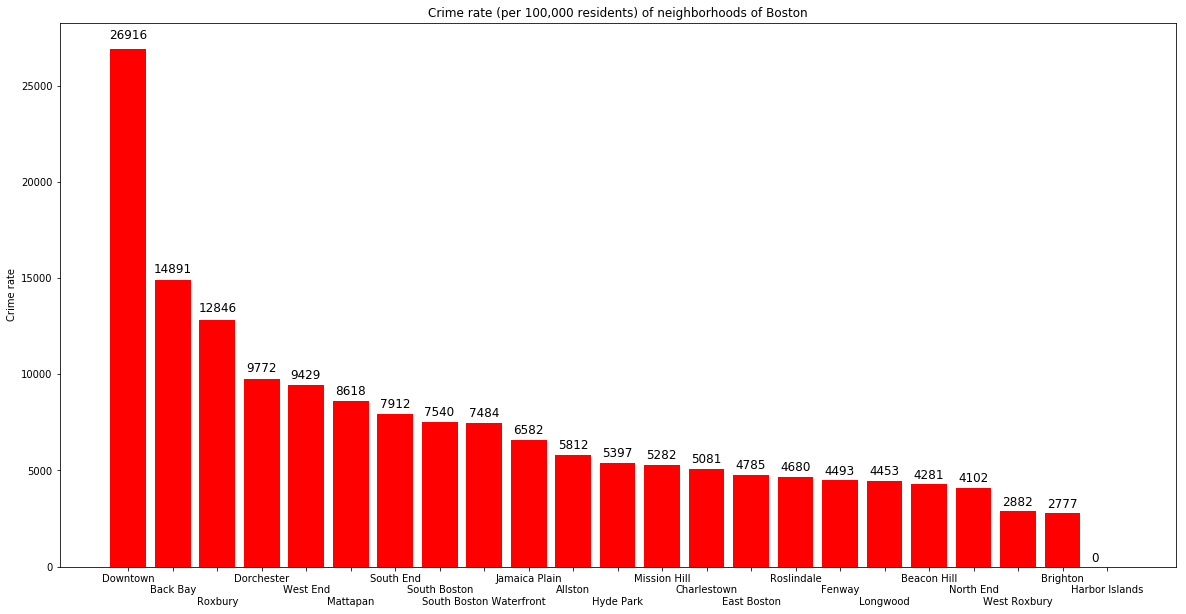

In [564]:
fig0 = plt.figure(figsize = (20,10))
ax0 = plt.subplot(111)
ind0 = np.arange(23)
crime_rate_by_neighborhood = df_nbh_full['Crime rate']
rects = ax0.bar(ind0, crime_rate_by_neighborhood, width = 0.8, color = 'r')
ax0.set_xticks(ind0)
ax0.set_xticklabels(multiliner(df_nbh_full.index.tolist(),3))
ax0.set_title('Crime rate (per 100,000 residents) of neighborhoods of Boston')
ax0.set_ylabel('Crime rate')
for rect in rects:
    height = rect.get_height()
    if height >= 9999.5:
        hor = rect.get_x() - 0.02
    else:
        hor = rect.get_x() + 0.05
    ax0.text(hor, 1.01 * height + 250, int(round(height)), fontsize = 12)

<a id = '4'></a>
[Return to top](#top)
# 4. Rates of particular crimes

Now let's focus on the actual categories UCR use. We will focus on violent crimes (defined as murder and nonnegligent manslaughter, rape, robbery, and aggravated assault), property crimes (burglary, larceny-theft, and motor vehicle theft) and arson. They are all UCR I crimes.